In [1]:
%run "All_helper_classes.ipynb" sort=False

#from "Models training helpers.ipynb" we will import 3 helper classes and the associated helper methods.
parsing_helpers = generic_parsing_helpers()
aivm_helper = AIVM_helper()
model_helpers, info = default_model_helpers_for_project()
#if you want to see the paths now can call with...
# # display (HTML(info))

paths = project_paths()

#same for paths and repo data, display using...
# display (HTML(paths.get_paths_data()))
# display (HTML(paths.get_repo_data()))

Using Theano backend.


Necessary libraries imported.
Initialised generic_parsing_helpers class and methods
Initialised AIVM_helper class and methods
Initialised model_helpers class and methods


In [2]:
%%javascript
//To remove scroll from any output area and automatically extend the jupyter cell
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;}

<IPython.core.display.Javascript object>

# First we will retrieve the most recently trained DL Models, Calibration Models and the Threshold.
these have been stored in the "Resource" directory of Git as a pickle file.
        * global_final_thresholds.pickle
        * {conv}_models.pickle
        * {conv}_calibration_model.pickle


In [3]:
#Read the latest models/Tresholds etc from GIT "Resource" directory.
USE_GIT_HUB = True


AI_GITHUB = "Data/ToBeAnalyzed/github_AI_repos_dump.csv"
REDDIT_AI = "Data/ToBeAnalyzed/reddit_data_all.csv"

# NON_AI_GITHUB = "Data/ToBeAnalyzed/github_non_AI_repos_dump.csv"
# SEM_SCHOLAR = ""


AI_GITHUB_GIT = "https://github.com/aideenf/AIVC/blob/master/cp_wssc/Data/ToBeAnalyzed/github_AI_repos_dump.csv?raw=true"
REDDIT_AI_GIT = "https://github.com/aideenf/AIVC/blob/master/cp_wssc/Data/ToBeAnalyzed/reddit_data_all.csv?raw=true"

# NON_AI_GITHUB_GIT = "Data/ToBeAnalyzed/github_non_AI_repos_dump.csv"
# SEM_SCHOLAR_GIT = ""


_DLModelsIsotonicRegression = {}
_DLModels = {}
_thresholds = {}
_tokenizer = ""

_thresholds = model_helpers.read_thresholds_from_pickle(USE_GIT_HUB)
display(_thresholds)

_DLModels = model_helpers.read_models_from_pickle(USE_GIT_HUB, _thresholds )
display(_DLModels)

_DLModelsIsotonicRegression = model_helpers.read_calibration_models_from_pickle(USE_GIT_HUB, _thresholds)
display(_DLModelsIsotonicRegression)

_tokenizer = model_helpers.read_tokenizer_from_pickle(USE_GIT_HUB)
display (_tokenizer)

Reading from GIT: global_final_thresholds.pickle?raw=true


{'civic': 0.5,
 'domestic': 0.5,
 'green': 0.5,
 'industrial': 0.5,
 'inspired': 0.5,
 'market': 0.5,
 'project': 0.5,
 'renown': 0.5}

Reading from GIT: civic_models.pickle?raw=true
Reading from GIT: domestic_models.pickle?raw=true
Reading from GIT: green_models.pickle?raw=true
Reading from GIT: industrial_models.pickle?raw=true
Reading from GIT: inspired_models.pickle?raw=true
Reading from GIT: market_models.pickle?raw=true
Reading from GIT: project_models.pickle?raw=true
Reading from GIT: renown_models.pickle?raw=true


{'civic': {'model': <keras.engine.training.Model at 0x1369a3f98>},
 'domestic': {'model': <keras.engine.training.Model at 0x136850d30>},
 'green': {'model': <keras.engine.training.Model at 0x136850c18>},
 'industrial': {'model': <keras.engine.training.Model at 0x1372e4cc0>},
 'inspired': {'model': <keras.engine.training.Model at 0x136ad7278>},
 'market': {'model': <keras.engine.training.Model at 0x1381a0fd0>},
 'project': {'model': <keras.engine.training.Model at 0x13b1ebf60>},
 'renown': {'model': <keras.engine.training.Model at 0x13b1f2f98>}}

Reading from GIT: civiccalibration_model.pickle?raw=true
Reading from GIT: domesticcalibration_model.pickle?raw=true
Reading from GIT: greencalibration_model.pickle?raw=true
Reading from GIT: industrialcalibration_model.pickle?raw=true
Reading from GIT: inspiredcalibration_model.pickle?raw=true
Reading from GIT: marketcalibration_model.pickle?raw=true
Reading from GIT: projectcalibration_model.pickle?raw=true
Reading from GIT: renowncalibration_model.pickle?raw=true


{'civic': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'domestic': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'green': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'industrial': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'inspired': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'market': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'project': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                     y_min=None)},
 'renown': {'model': IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
                    

Reading from GIT: extended_tokenizer.pickle?raw=true


{'tokenizer': <keras_preprocessing.text.Tokenizer at 0x13b1d8438>}

In [64]:
# This method will use the trained classification and calibration models to predict and quantify 
# the presence of conventions in new data(the data to be analyzed)
 
def predict_scores_and_classify(thresholds_in, to_predict_df, _tokenizer, _DLModels, _DLModelsIsotonicRegression, seq_len):
    
    predict = True
     
    extended_tokenizer = _tokenizer
        
    sequences = extended_tokenizer.texts_to_sequences(to_predict_df['text'])
    data = pad_sequences(sequences, maxlen= seq_len) 
    extended_tokenizer = 0
    sequences = 0
    gc.collect()
    
    thresholds = {'civic': 0.5,
                  'domestic': 0.5,
                  'green': 0.5,
                  'industrial': 0.5,
                  'inspired': 0.5,
                  'market': 0.5,
                  'project': 0.5,
                  'renown': 0.5}
    # otherwise use default.
    
    if thresholds_in != None:
        thresholds = thresholds_in
       
    column_list = []
    column_list.append("repo_id")
    column_list.append("text")
    column_list.append("repo")
    
    for conv in _DLModels.keys():
        column_list.append(conv)
        column_list.append(conv+"_prob")
        column_list.append(conv+"_y_pred")
        column_list.append(conv+"_prob_1")
        
    df = pd.DataFrame(columns=column_list)
    all_df = pd.DataFrame(columns=column_list)
    
    ###################
    #a sub function within the function, just used in this scope 
    def sub_funct_get_prob(prob, y):
        res = []
        for (probability, predicted) in zip(prob, y):
            if predicted == 1:
                res.append(probability)
            if predicted == 0:
                res.append(1 - probability)
        return res
    ####################

    df = pd.DataFrame(columns=column_list)
    
    #get the the txt of the sentence to be Analyzed
    df['text'] = to_predict_df["text"]
    df['repo_id'] = to_predict_df["repo_id"]
    df['repo'] = to_predict_df["repo"]

        

    for model in _DLModels.keys():
        my_model = _DLModels[model]           
        #First through the model
        y_predict = my_model['model'].predict(data)
                
        #get the score for value = 1 as the response is [x,y] we need only the y values
        y_pos_predict_prob = model_helpers.get_positive_preds_probabilities(y_predict)
                
        #get the 1 or 0 value depending on the threshold
        y_pred = model_helpers.get_positive_preds_with_threshold(y_pos_predict_prob, thresholds[model])
                
        #if the call has been made with an isotonic reg calibration model too then call its predict.
        if _DLModelsIsotonicRegression != None:
            other_ir = _DLModelsIsotonicRegression[model]
            y_pos_predict_isotonic_prob = other_ir['model'].predict(y_pos_predict_prob)
            y_pred = model_helpers.get_positive_preds_with_threshold(y_pos_predict_isotonic_prob, thresholds[model])
            y_pos_predict_prob = y_pos_predict_isotonic_prob
                
        #The probability of the y_predict, whether it i 1 or 0
        df[model+"_prob"] =  sub_funct_get_prob(y_pos_predict_prob, y_pred)
        df[model+"_y_pred"] = y_pred
        df[model+"_prob_1"] = y_pos_predict_prob         
        
   
    y_pred_list = []
    for x in df.columns.values:
        if x.endswith(('_y_pred')):
            y_pred_list.append(x)
            
    prob_list = []
    conv_list = []
    for x in df.columns.values:
        if x.endswith(('_prob')):
            prob_list.append(x)
            conv_list.append(x.replace('_prob', ''))
    
    if predict == True:
        #add the label cardinality as the sum of all the predicted = 1 for sentence for conventions
        pred_sums = df[y_pred_list].sum(axis=1)
        df['lbl_cnt'] = pred_sums
        #add the overall score as the product of all the individual predicted convention scores
        prob_product= all_df[prob_list].prod(axis=1)
        df['set_conf'] = prob_product
    
    
    #this will be > 1 if the same sentence was used as True for 2 or more conventions.
    positive_sample = df[conv_list].sum(axis=1)
    df['pos_sample'] = positive_sample
     
    print ("Num Dupes:", len(df.index) - len(df['text'].unique()) )

    #now we are droppping the dupes but we should not. 
    df = df.drop_duplicates(keep = "first")
    
    co_occur_list = []
    rename = []
    for x in df.columns.values:
            if x.endswith(('_y_pred')):
                co_occur_list.append(x)
                rename.append(x.replace('_y_pred', ''))

    co_occur_y_predict = df[co_occur_list].copy()
    for old, x in zip(co_occur_list, range(len(co_occur_list))): 
        co_occur_y_predict = co_occur_y_predict.rename(columns={old: rename[x]})
        
    plt.figure(figsize=(10,5))
    plt.style.use('seaborn-dark-palette')
        
    text = "Predicted Co-occurance Matrix with Predicted and Actual Cardinality "
    display (HTML("<font color = green><h3><left>" + text + "</left></h3></font>"))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = model_helpers.co_occurance_matrix (co_occur_y_predict)

    ax2 = plt.subplot(1, 2, 2)
    ax2 = model_helpers.label_cardinality_bar(co_occur_y_predict, title = "Predicted Cardinality") 
    plt.show()   
    return df.fillna(0), thresholds


def clean_descriptions (text):

    #remove snippets of code
    text = re.sub("```.*?```", " ", text)
    
    #https://regex101.com/r/cO8lqs/2
    text = re.sub("b'", ' ', text)
    
    text = re.sub("i\.e\.", 'i.e', text)
    text = re.sub("e\.g\.", 'e.g', text)
    
    # remove anything with this format "[![text]...."
    text = re.sub(r'\[\!.*?\)', ' ', text)
    
    
        
    # remove anything with this format "([.....))."
    text = re.sub(r'\(\[.*?\)\)\.', ' ', text)
    
    
    # remove anything with this format "([.....))"
    text = re.sub(r'\(\[.*?\)\)', ' ', text)
    
    
    # remove headers and replace with full stop, in case a previous sentence doed not have it
    text = re.sub(r'\#.*?\n', ' ', text)
    
    #remove HTML tags
    text = re.sub("(<.*?>)","",text)
    
    #remove URL's
    text = re.sub(r'\(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text, flags=re.MULTILINE)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text, flags=re.MULTILINE)

    #remove new lines as they are not correctly formatted
    text = text.replace('\\n', " ")
    text = text.replace('\n', " ")



    #r
    text = text.replace("\\'", "'")
    text = text.replace("\'", "'")
    
    # remove anything with this format "[![text]"
    text = re.sub(r'\[\!.*?\]', ' ', text)
    
    
    #remove tables
    text = re.sub(r"[\|].*?[\|]", "||", text)
    
    text = re.sub(r"[^a-zA-Z0-9.,'-|]",' ', text)    
    text = text.replace("[", "")
    text = text.replace("]", "")
    text = text.replace("--", "")
    text = text.replace(" -", "")
    text = text.replace("- ", "")
    text = re.sub(' +', ' ', text)
   
    new_list = []
    text_list = text.split('||')
    for line in text_list:
        if len(line) > 25:
            new_list.append(line +'\n')
    text = ''   
    text = text.join(new_list)
    text = text.replace("*", "")
    text = text.replace("\\n", ".")
    text = text.replace("\n", ".")

    text = text.replace(" .", ".")
    text = text.replace("..", ".")
    text = text.lstrip()
    text = text.rstrip()
    text = text.strip()
    
    text = re.sub(r"[\\][x][0-9][0-9][0-9]", "", text)
    text = re.sub(r"[\\][x][a-z][0-9]", "", text)
    text = re.sub(r"[\\][x][a-z][a-z]", "", text)
    text = re.sub(r"[\\][x][0-9][0-9]", "", text)
    text = re.sub(r"[\\][x][a-z]", "", text)
    text = re.sub(r"[\\][x][0-9]", "", text)
    text = re.sub(r"[\\][x]", " ", text)
    text_list = text.split('. ')
    new_list = []
    for line in text_list:
        
        line = line.strip()
        line = line.capitalize() + '.\n'
        new_list.append(line)
    text = ''   
    text = text.join(new_list)
    
    text = re.sub('\.__', ' ', text)
    text = re.sub('__\.', ' ', text)
    text = re.sub('__' ,'', text)
    text = re.sub('>_' ,'', text)
    text = re.sub('/' ,' ', text)
    text = re.sub('{' ,'', text)
    text = re.sub('Image::' ,'', text)
    text = re.sub(r"=","",text)
    text = re.sub(r"\r","",text)
    text = re.sub(r"\(\)","",text)
    text = text.replace(" .", ".")
    text = text.replace("..", ".")
    text = text.replace(">", "")
    text = text.replace(":height:", "")
    text = text.replace(".. image::", "")
    text = text.replace(":target:", "")
    text = text.replace(":alt:", "")
    text = text.replace("`_", "`")
    text = text.replace("^", "")
    text = text.replace("Code-block::", "")
    text = text.replace(":start-offset", "")
    text = text.replace(":end-offset", "")
    text = text.replace("\\\\", "\\")
    text = text.replace("\t", " ")
    text = text.replace("image::", " ")
    text = re.sub(' +', ' ', text)
    

    return text


def create_pd_from_repo(AI_texts, AI_repo_id, AI_repo_name ):
    # for every repo in the AI_texts file, 
    # get the raw description
    # process it
    # convert to an array of sentences
    # add each individual sentence to a pandas
    # add the repo ID to the pandas.  in the end we will 
    # have a pandas DB with repo_id and text to be predicted.
    # only add the text if it is more than 40 letters long
    print ("num AI repos", len ( AI_texts))
    
    df_all = pd.DataFrame()
    for x in range(len(AI_texts)):
        df = pd.DataFrame()
        sent = AI_texts[x]
        repo_id = AI_repo_id[x]
        repo_name = AI_repo_name[x]
        sen_arr = clean_descriptions(sent).split("\n")
        df['text'] = sen_arr
        df['repo_id'] = repo_id
        df['repo'] = repo_name
        df=df[df.text.apply(lambda x: len(str(x))>50)]
        df_all = pd.concat([df_all, df])
    print ("full list length",df_all.shape[0] )
    
    return df_all

def analyze_git_repo(url, thresholds, tokenizer, DLModels, DLModelsIsotonicRegression, model_helpers):
    AI_repos = pd.read_csv(url, sep=";")
    
    AI_texts = AI_repos['repo_raw_description'].values
    AI_repo_id = AI_repos['repo_id'].values
    AI_repo_name = AI_repos['repo_name'].values
    AI_repos = 0
    gc.collect()
    res, _ = predict_scores_and_classify(thresholds, create_pd_from_repo(AI_texts, AI_repo_id, AI_repo_name ), tokenizer, DLModels, DLModelsIsotonicRegression, model_helpers.MAX_SEQUENCE_LENGTH)
    AI_repos = 0
    AI_texts = 0
    AI_repo_id = 0

    text = "Probabilistic count v's Classification count"
    display (HTML("<font color = green><h4><left>" + text + "</left></h4></font>"))
    display (model_helpers.get_count(res, _DLModels, thresholds, num_prob_buckets = 8, actual=False ))
    return res

# Classify GitHub AI repo with latest models

    _DLModelsIsotonicRegression 
    _DLModels
    _thresholds
    _tokenizer

num AI repos 8609
full list length 134608
Num Dupes: 5489


,civic,domestic,green,industrial,inspired,market,project,renown
civic,397.0,6.0,2.0,31.0,1.0,19.0,8.0,3.0
domestic,6.0,237.0,0.0,14.0,9.0,85.0,23.0,0.0
green,2.0,0.0,128.0,7.0,0.0,3.0,0.0,0.0
industrial,31.0,14.0,7.0,80608.0,185.0,1743.0,159.0,1.0
inspired,1.0,9.0,0.0,185.0,385.0,17.0,3.0,0.0
market,19.0,85.0,3.0,1743.0,17.0,3805.0,56.0,1.0
project,8.0,23.0,0.0,159.0,3.0,56.0,469.0,1.0
renown,3.0,0.0,0.0,1.0,0.0,1.0,1.0,22.0


,civic,domestic,green,industrial,inspired,market,project,renown
civic,1.00,0.01,0.0,0.00,0.00,0.00,0.01,0.01
domestic,0.01,1.00,0.0,0.00,0.01,0.02,0.03,0.00
green,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00
industrial,0.00,0.00,0.0,1.00,0.00,0.02,0.00,0.00
inspired,0.00,0.01,0.0,0.00,1.00,0.00,0.00,0.00
market,0.00,0.02,0.0,0.02,0.00,1.00,0.01,0.00
project,0.01,0.03,0.0,0.00,0.00,0.01,1.00,0.00
renown,0.01,0.00,0.0,0.00,0.00,0.00,0.00,1.00


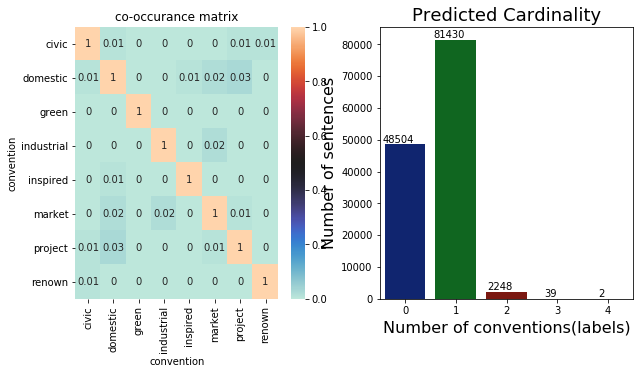

None

<Figure size 432x288 with 0 Axes>

In [65]:
temp = pd.DataFrame()
ai_repo_analysis_df = analyze_git_repo(AI_GITHUB_GIT, _thresholds, _tokenizer['tokenizer'], _DLModels, _DLModelsIsotonicRegression, model_helpers)

# group by repo-id

In [66]:
display (ai_repo_analysis_df.head(4))
display(ai_repo_analysis_df.shape[0])

sum_list = []
for conv in _thresholds:
    sum_list.append(conv+'_y_pred')
ai_repo_analysis_df['text'] = ai_repo_analysis_df['text'] + '['
for conv_pred in sum_list:
    print(conv_pred)
    ai_repo_analysis_df['text'] = ai_repo_analysis_df["text"].map(str) +  ai_repo_analysis_df[conv_pred].map(str) +','
ai_repo_analysis_df['text'] = ai_repo_analysis_df['text'] + "]."
print ("done") 


display(ai_repo_analysis_df.shape[0])
display(ai_repo_analysis_df.head(4))
display(ai_repo_analysis_df.iloc[0][1])

,repo_id,text,repo,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,lbl_cnt,set_conf,pos_sample
0,45717250,Tensorflow is an end-to-end open source platfo...,tensorflow/tensorflow,0,0.953488,0,0.046512,0,1.000000,0,...,0.833333,0,0.166667,0,0.944444,0,0.055556,1,0.0,0.0
1,45717250,"It has a comprehensive, flexible ecosystem of ...",tensorflow/tensorflow,0,1.000000,0,0.000000,0,1.000000,0,...,1.000000,0,0.000000,0,1.000000,0,0.000000,0,0.0,0.0
2,45717250,Tensorflow was originally developed by researc...,tensorflow/tensorflow,0,1.000000,0,0.000000,0,1.000000,0,...,0.882353,0,0.117647,0,0.980392,0,0.019608,0,0.0,0.0
3,45717250,The system is general enough to be applicable ...,tensorflow/tensorflow,0,0.953488,0,0.046512,0,0.964286,0,...,0.948276,0,0.051724,0,0.957447,0,0.042553,1,0.0,0.0


132223

civic_y_pred
domestic_y_pred
green_y_pred
industrial_y_pred
inspired_y_pred
market_y_pred
project_y_pred
renown_y_pred
done


132223

,repo_id,text,repo,civic,civic_prob,civic_y_pred,civic_prob_1,domestic,domestic_prob,domestic_y_pred,...,project_prob,project_y_pred,project_prob_1,renown,renown_prob,renown_y_pred,renown_prob_1,lbl_cnt,set_conf,pos_sample
0,45717250,Tensorflow is an end-to-end open source platfo...,tensorflow/tensorflow,0,0.953488,0,0.046512,0,1.000000,0,...,0.833333,0,0.166667,0,0.944444,0,0.055556,1,0.0,0.0
1,45717250,"It has a comprehensive, flexible ecosystem of ...",tensorflow/tensorflow,0,1.000000,0,0.000000,0,1.000000,0,...,1.000000,0,0.000000,0,1.000000,0,0.000000,0,0.0,0.0
2,45717250,Tensorflow was originally developed by researc...,tensorflow/tensorflow,0,1.000000,0,0.000000,0,1.000000,0,...,0.882353,0,0.117647,0,0.980392,0,0.019608,0,0.0,0.0
3,45717250,The system is general enough to be applicable ...,tensorflow/tensorflow,0,0.953488,0,0.046512,0,0.964286,0,...,0.948276,0,0.051724,0,0.957447,0,0.042553,1,0.0,0.0


'Tensorflow is an end-to-end open source platform for machine learning.[0,0,0,1,0,0,0,0,].'

In [67]:
sum_list = []
for conv in _thresholds:
    sum_list.append(conv+'_y_pred')
sum_list.append("text")
grouped_ai_repo_analysis_df = ai_repo_analysis_df.groupby(['repo_id', 'repo'])
grouped_ai_repo_analysis_df = grouped_ai_repo_analysis_df[sum_list].sum(axis=0)

def applyFunc(s): 
    return len(s.split(' '))
def numSen(s): 
    return len(s.split('].'))

grouped_ai_repo_analysis_df['word_count'] = grouped_ai_repo_analysis_df['text'].apply(applyFunc)
grouped_ai_repo_analysis_df['sentence_count'] = grouped_ai_repo_analysis_df['text'].apply(numSen)


print ("The number of repos is", grouped_ai_repo_analysis_df.shape[0])
grouped_ai_repo_analysis_df = grouped_ai_repo_analysis_df.reset_index()
grouped_ai_repo_analysis_df['word_count'] = grouped_ai_repo_analysis_df['text'].apply(applyFunc)
display(grouped_ai_repo_analysis_df.head(2))

The number of repos is 8457


,repo_id,repo,civic_y_pred,domestic_y_pred,green_y_pred,industrial_y_pred,inspired_y_pred,market_y_pred,project_y_pred,renown_y_pred,text,word_count,sentence_count
0,102637,cirg-up/cilib,0,0,0,2,0,0,0,0,Cilib computational intelligence library is a ...,169,5
1,135191,igrigorik/decisiontree,0,0,0,8,0,0,0,0,Decision tree a ruby library which implements ...,186,10


In [68]:
f1=open('./analysis.html', 'w+')

i = 0

for x in range(100):
    i = x + 1
    print("****************************EXAMPLE",i+1, "************************************")
    html = ""
    print("Number of words:", grouped_ai_repo_analysis_df.iloc[i][11])
    print("Number of sentences:", grouped_ai_repo_analysis_df.iloc[i][12])
    print("Total civic:", grouped_ai_repo_analysis_df.iloc[i][2])
    print("Total domestic:", grouped_ai_repo_analysis_df.iloc[i][3])
    print("Total green:", grouped_ai_repo_analysis_df.iloc[i][4])
    print("Total industrial:", grouped_ai_repo_analysis_df.iloc[i][5])
    print("Total inspired:", grouped_ai_repo_analysis_df.iloc[i][6])
    print("Total market:", grouped_ai_repo_analysis_df.iloc[i][7])
    print("Total project:", grouped_ai_repo_analysis_df.iloc[i][8])
    print("Total renown:", grouped_ai_repo_analysis_df.iloc[i][9])
    print("URL:", 'https://github.com/' + grouped_ai_repo_analysis_df.iloc[i][1] + '/blob/master/README.md')
    print("URL:", 'https://github.com/' + grouped_ai_repo_analysis_df.iloc[i][1] + '/blob/master/README.rst')
    
    f1.write("<br/>****************************EXAMPLE" + str( i+1) + "************************************")
    f1.write("<br/>Number of words:"+ str( grouped_ai_repo_analysis_df.iloc[i][11]))
    f1.write("<br/>Number of sentences:"+ str( grouped_ai_repo_analysis_df.iloc[i][12]))
    f1.write("<br/>Total civic:"+ str( grouped_ai_repo_analysis_df.iloc[i][2]))
    f1.write("<br/>Total domestic:"+ str( grouped_ai_repo_analysis_df.iloc[i][3]))
    f1.write("<br/>Total green:"+ str( grouped_ai_repo_analysis_df.iloc[i][4]))
    f1.write("<br/>Total industrial:"+ str( grouped_ai_repo_analysis_df.iloc[i][5]))
    f1.write("<br/>Total inspired:"+ str( grouped_ai_repo_analysis_df.iloc[i][6]))
    f1.write("<br/>Total market:"+ str( grouped_ai_repo_analysis_df.iloc[i][7]))
    f1.write("<br/>Total project:"+ str( grouped_ai_repo_analysis_df.iloc[i][8]))
    f1.write("<br/>Total renown:"+ str( grouped_ai_repo_analysis_df.iloc[i][9]))
    f1.write("<br/><a href='https://github.com/" 
             + grouped_ai_repo_analysis_df.iloc[i][1] 
             + "/blob/master/README.md'>https://github.com/" 
             + grouped_ai_repo_analysis_df.iloc[i][1] 
             + "/blob/master/README.md</a>")
    
    f1.write("<br/><a href='https://github.com/" 
             + grouped_ai_repo_analysis_df.iloc[i][1] 
             + "/blob/master/README.rst'>https://github.com/" 
             + grouped_ai_repo_analysis_df.iloc[i][1] 
             + "/blob/master/README.rst</a>")
    sen_arr = grouped_ai_repo_analysis_df.iloc[i][10].split("].")

    print("")

    for sen in sen_arr:
        try:
            parts = sen.split("[")
            tags = parts[1].split(",")
            del tags[-1]
            tags = list(map(int, tags))
            sum_list = []
            count = 0
            conventions = ""
            for conv, x in zip(_thresholds, range(len(tags))):
                if conv == "industrial":
                    color = 'red'
                if conv == "civic":
                    color = 'blue'
                if conv == "domestic":
                    color = 'purple'  
                if conv == "market":
                    color = 'violet'  
                if conv == "project":
                    color = 'orange' 
                if conv == "green":
                    color = 'green'  
                add_text = "<font color=" + color + ">" + conv + ', ' + "</font>"
                
                if tags[x] == 1:
                    conventions =  conventions + add_text  + " "
                    count = count + 1
            
            
            if (count > 0):
                conventions = conventions[:-10]+"</font>"
             
                html = html + " " + "<b>" + parts[0][:-1] + "</b>" + "[" + conventions + "]" + '<b>.</b>'
            else:
                html = html +  " " + parts[0]

        except:
            print("")
    display(HTML(html))
    f1.write("<br/>")
    f1.write("<br/>")
    f1.write( html)
    f1.write("<br/>")
    f1.write("<br/>")
    print("")
    print("")
    print("")
f1.close()

****************************EXAMPLE 2 ************************************
Number of words: 186
Number of sentences: 10
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/igrigorik/decisiontree/blob/master/README.md
URL: https://github.com/igrigorik/decisiontree/blob/master/README.rst







****************************EXAMPLE 3 ************************************
Number of words: 315
Number of sentences: 18
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 9
Total inspired: 0
Total market: 2
Total project: 1
Total renown: 0
URL: https://github.com/febeling/rb-libsvm/blob/master/README.md
URL: https://github.com/febeling/rb-libsvm/blob/master/README.rst







****************************EXAMPLE 4 ************************************
Number of words: 573
Number of sentences: 29
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 20
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/rieck/malheur/blob/master/README.md
URL: https://github.com/rieck/malheur/blob/master/README.rst







****************************EXAMPLE 5 ************************************
Number of words: 315
Number of sentences: 15
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 10
Total inspired: 0
Total market: 2
Total project: 0
Total renown: 0
URL: https://github.com/jblas-project/jblas/blob/master/README.md
URL: https://github.com/jblas-project/jblas/blob/master/README.rst







****************************EXAMPLE 6 ************************************
Number of words: 265
Number of sentences: 15
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 10
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/VowpalWabbit/vowpal_wabbit/blob/master/README.md
URL: https://github.com/VowpalWabbit/vowpal_wabbit/blob/master/README.rst







****************************EXAMPLE 7 ************************************
Number of words: 177
Number of sentences: 11
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 5
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/nltk/nltk/blob/master/README.md
URL: https://github.com/nltk/nltk/blob/master/README.rst







****************************EXAMPLE 8 ************************************
Number of words: 154
Number of sentences: 11
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/nipy/dipy/blob/master/README.md
URL: https://github.com/nipy/dipy/blob/master/README.rst







****************************EXAMPLE 9 ************************************
Number of words: 71
Number of sentences: 5
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 3
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/kawatan/Apricot/blob/master/README.md
URL: https://github.com/kawatan/Apricot/blob/master/README.rst







****************************EXAMPLE 10 ************************************
Number of words: 362
Number of sentences: 21
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 19
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/proycon/pynlpl/blob/master/README.md
URL: https://github.com/proycon/pynlpl/blob/master/README.rst







****************************EXAMPLE 11 ************************************
Number of words: 507
Number of sentences: 24
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 20
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/rieck/sally/blob/master/README.md
URL: https://github.com/rieck/sally/blob/master/README.rst







****************************EXAMPLE 12 ************************************
Number of words: 403
Number of sentences: 23
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 12
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/scikit-learn/scikit-learn/blob/master/README.md
URL: https://github.com/scikit-learn/scikit-learn/blob/master/README.rst







****************************EXAMPLE 13 ************************************
Number of words: 284
Number of sentences: 12
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 10
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/ramhiser/datamicroarray/blob/master/README.md
URL: https://github.com/ramhiser/datamicroarray/blob/master/README.rst







****************************EXAMPLE 14 ************************************
Number of words: 106
Number of sentences: 5
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 4
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/ramhiser/sparsediscrim/blob/master/README.md
URL: https://github.com/ramhiser/sparsediscrim/blob/master/README.rst







****************************EXAMPLE 15 ************************************
Number of words: 157
Number of sentences: 9
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 6
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/bytefish/opencv/blob/master/README.md
URL: https://github.com/bytefish/opencv/blob/master/README.rst







****************************EXAMPLE 16 ************************************
Number of words: 125
Number of sentences: 7
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 6
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/lutzroeder/netron/blob/master/README.md
URL: https://github.com/lutzroeder/netron/blob/master/README.rst







****************************EXAMPLE 17 ************************************
Number of words: 158
Number of sentences: 9
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 6
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/nilearn/nilearn/blob/master/README.md
URL: https://github.com/nilearn/nilearn/blob/master/README.rst







****************************EXAMPLE 18 ************************************
Number of words: 460
Number of sentences: 19
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 12
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/mne-tools/mne-python/blob/master/README.md
URL: https://github.com/mne-tools/mne-python/blob/master/README.rst







****************************EXAMPLE 19 ************************************
Number of words: 655
Number of sentences: 34
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 26
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/RaRe-Technologies/gensim/blob/master/README.md
URL: https://github.com/RaRe-Technologies/gensim/blob/master/README.rst







****************************EXAMPLE 20 ************************************
Number of words: 226
Number of sentences: 14
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 1
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/telmomenezes/synthetic/blob/master/README.md
URL: https://github.com/telmomenezes/synthetic/blob/master/README.rst







****************************EXAMPLE 21 ************************************
Number of words: 240
Number of sentences: 16
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 14
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/shogun-toolbox/shogun/blob/master/README.md
URL: https://github.com/shogun-toolbox/shogun/blob/master/README.rst







****************************EXAMPLE 22 ************************************
Number of words: 110
Number of sentences: 6
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 3
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/kevinjalbert/kmean_clustering/blob/master/README.md
URL: https://github.com/kevinjalbert/kmean_clustering/blob/master/README.rst







****************************EXAMPLE 23 ************************************
Number of words: 550
Number of sentences: 25
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 14
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/JuliaLang/julia/blob/master/README.md
URL: https://github.com/JuliaLang/julia/blob/master/README.rst







****************************EXAMPLE 24 ************************************
Number of words: 505
Number of sentences: 19
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 7
Total inspired: 0
Total market: 2
Total project: 0
Total renown: 0
URL: https://github.com/clips/pattern/blob/master/README.md
URL: https://github.com/clips/pattern/blob/master/README.rst







****************************EXAMPLE 25 ************************************
Number of words: 99
Number of sentences: 3
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/wellflat/imageprocessing-labs/blob/master/README.md
URL: https://github.com/wellflat/imageprocessing-labs/blob/master/README.rst







****************************EXAMPLE 26 ************************************
Number of words: 574
Number of sentences: 35
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 30
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/sqrlab/MutationScorePredictor/blob/master/README.md
URL: https://github.com/sqrlab/MutationScorePredictor/blob/master/README.rst







****************************EXAMPLE 27 ************************************
Number of words: 714
Number of sentences: 22
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 15
Total inspired: 0
Total market: 3
Total project: 0
Total renown: 0
URL: https://github.com/inukshuk/anystyle/blob/master/README.md
URL: https://github.com/inukshuk/anystyle/blob/master/README.rst







****************************EXAMPLE 28 ************************************
Number of words: 131
Number of sentences: 8
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 3
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/evllabs/JGAAP/blob/master/README.md
URL: https://github.com/evllabs/JGAAP/blob/master/README.rst







****************************EXAMPLE 29 ************************************
Number of words: 268
Number of sentences: 10
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/xrobin/pROC/blob/master/README.md
URL: https://github.com/xrobin/pROC/blob/master/README.rst







****************************EXAMPLE 30 ************************************
Number of words: 12
Number of sentences: 2
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/sanity/quickml/blob/master/README.md
URL: https://github.com/sanity/quickml/blob/master/README.rst







****************************EXAMPLE 31 ************************************
Number of words: 175
Number of sentences: 7
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/ramhiser/activelearning/blob/master/README.md
URL: https://github.com/ramhiser/activelearning/blob/master/README.rst







****************************EXAMPLE 32 ************************************
Number of words: 247
Number of sentences: 16
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 12
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/jubatus/jubatus/blob/master/README.md
URL: https://github.com/jubatus/jubatus/blob/master/README.rst







****************************EXAMPLE 33 ************************************
Number of words: 9
Number of sentences: 2
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/fcurella/django-recommends/blob/master/README.md
URL: https://github.com/fcurella/django-recommends/blob/master/README.rst







****************************EXAMPLE 34 ************************************
Number of words: 1383
Number of sentences: 50
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 28
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/Artificial-Engineering/lycheejs/blob/master/README.md
URL: https://github.com/Artificial-Engineering/lycheejs/blob/master/README.rst







****************************EXAMPLE 35 ************************************
Number of words: 351
Number of sentences: 17
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/clojurenlp/core/blob/master/README.md
URL: https://github.com/clojurenlp/core/blob/master/README.rst







****************************EXAMPLE 36 ************************************
Number of words: 991
Number of sentences: 30
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 27
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/foo123/FILTER.js/blob/master/README.md
URL: https://github.com/foo123/FILTER.js/blob/master/README.rst







****************************EXAMPLE 37 ************************************
Number of words: 247
Number of sentences: 10
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 4
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/mbq/rFerns/blob/master/README.md
URL: https://github.com/mbq/rFerns/blob/master/README.rst







****************************EXAMPLE 38 ************************************
Number of words: 111
Number of sentences: 5
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/GHamrouni/Recommender/blob/master/README.md
URL: https://github.com/GHamrouni/Recommender/blob/master/README.rst







****************************EXAMPLE 39 ************************************
Number of words: 285
Number of sentences: 13
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 9
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/scikit-learn-contrib/lightning/blob/master/README.md
URL: https://github.com/scikit-learn-contrib/lightning/blob/master/README.rst







****************************EXAMPLE 40 ************************************
Number of words: 282
Number of sentences: 15
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 11
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/kevincobain2000/sentiment_classifier/blob/master/README.md
URL: https://github.com/kevincobain2000/sentiment_classifier/blob/master/README.rst







****************************EXAMPLE 41 ************************************
Number of words: 178
Number of sentences: 6
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/nmap/nmap/blob/master/README.md
URL: https://github.com/nmap/nmap/blob/master/README.rst







****************************EXAMPLE 42 ************************************
Number of words: 728
Number of sentences: 41
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 20
Total inspired: 0
Total market: 2
Total project: 0
Total renown: 0
URL: https://github.com/ptnplanet/Java-Naive-Bayes-Classifier/blob/master/README.md
URL: https://github.com/ptnplanet/Java-Naive-Bayes-Classifier/blob/master/README.rst







****************************EXAMPLE 43 ************************************
Number of words: 53
Number of sentences: 6
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 5
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/OpenANN/OpenANN/blob/master/README.md
URL: https://github.com/OpenANN/OpenANN/blob/master/README.rst







****************************EXAMPLE 44 ************************************
Number of words: 618
Number of sentences: 12
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/accord-net/framework/blob/master/README.md
URL: https://github.com/accord-net/framework/blob/master/README.rst







****************************EXAMPLE 45 ************************************
Number of words: 33
Number of sentences: 2
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/bytefish/machinelearning-opencv/blob/master/README.md
URL: https://github.com/bytefish/machinelearning-opencv/blob/master/README.rst







****************************EXAMPLE 46 ************************************
Number of words: 1843
Number of sentences: 82
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 54
Total inspired: 0
Total market: 3
Total project: 1
Total renown: 0
URL: https://github.com/bigmlcom/python/blob/master/README.md
URL: https://github.com/bigmlcom/python/blob/master/README.rst







****************************EXAMPLE 47 ************************************
Number of words: 68
Number of sentences: 3
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/loli/medpy/blob/master/README.md
URL: https://github.com/loli/medpy/blob/master/README.rst







****************************EXAMPLE 48 ************************************
Number of words: 17
Number of sentences: 2
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/sebadorn/Machine-Learning--Connect-Four/blob/master/README.md
URL: https://github.com/sebadorn/Machine-Learning--Connect-Four/blob/master/README.rst







****************************EXAMPLE 49 ************************************
Number of words: 155
Number of sentences: 6
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/comic/grand-challenge.org/blob/master/README.md
URL: https://github.com/comic/grand-challenge.org/blob/master/README.rst







****************************EXAMPLE 50 ************************************
Number of words: 544
Number of sentences: 35
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 21
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/yassersouri/classify-text/blob/master/README.md
URL: https://github.com/yassersouri/classify-text/blob/master/README.rst







****************************EXAMPLE 51 ************************************
Number of words: 312
Number of sentences: 20
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 15
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/profjsb/python-seminar/blob/master/README.md
URL: https://github.com/profjsb/python-seminar/blob/master/README.rst







****************************EXAMPLE 52 ************************************
Number of words: 256
Number of sentences: 8
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/mne-tools/mne-cpp/blob/master/README.md
URL: https://github.com/mne-tools/mne-cpp/blob/master/README.rst







****************************EXAMPLE 53 ************************************
Number of words: 216
Number of sentences: 15
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 11
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/PRML/PRMLT/blob/master/README.md
URL: https://github.com/PRML/PRMLT/blob/master/README.rst







****************************EXAMPLE 54 ************************************
Number of words: 285
Number of sentences: 11
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 3
Total inspired: 0
Total market: 0
Total project: 1
Total renown: 0
URL: https://github.com/wvrossem/FIPS-Android-Offline/blob/master/README.md
URL: https://github.com/wvrossem/FIPS-Android-Offline/blob/master/README.rst







****************************EXAMPLE 55 ************************************
Number of words: 252
Number of sentences: 10
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 5
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/wvrossem/FIPS-Android-Online/blob/master/README.md
URL: https://github.com/wvrossem/FIPS-Android-Online/blob/master/README.rst







****************************EXAMPLE 56 ************************************
Number of words: 236
Number of sentences: 9
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 3
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/wvrossem/FIPS/blob/master/README.md
URL: https://github.com/wvrossem/FIPS/blob/master/README.rst







****************************EXAMPLE 57 ************************************
Number of words: 1384
Number of sentences: 35
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 21
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/kermitt2/grobid/blob/master/README.md
URL: https://github.com/kermitt2/grobid/blob/master/README.rst







****************************EXAMPLE 58 ************************************
Number of words: 497
Number of sentences: 24
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 18
Total inspired: 0
Total market: 4
Total project: 0
Total renown: 0
URL: https://github.com/crcollins/chemtools-webapp/blob/master/README.md
URL: https://github.com/crcollins/chemtools-webapp/blob/master/README.rst







****************************EXAMPLE 59 ************************************
Number of words: 603
Number of sentences: 18
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 13
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/CeON/CERMINE/blob/master/README.md
URL: https://github.com/CeON/CERMINE/blob/master/README.rst







****************************EXAMPLE 60 ************************************
Number of words: 1586
Number of sentences: 67
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 49
Total inspired: 0
Total market: 2
Total project: 0
Total renown: 0
URL: https://github.com/lisitsyn/tapkee/blob/master/README.md
URL: https://github.com/lisitsyn/tapkee/blob/master/README.rst







****************************EXAMPLE 61 ************************************
Number of words: 203
Number of sentences: 14
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 2
Total project: 1
Total renown: 0
URL: https://github.com/malavbhavsar/sentimentalizer/blob/master/README.md
URL: https://github.com/malavbhavsar/sentimentalizer/blob/master/README.rst







****************************EXAMPLE 62 ************************************
Number of words: 382
Number of sentences: 9
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 6
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/nanxstats/protr/blob/master/README.md
URL: https://github.com/nanxstats/protr/blob/master/README.rst







****************************EXAMPLE 63 ************************************
Number of words: 573
Number of sentences: 20
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/dnouri/nolearn/blob/master/README.md
URL: https://github.com/dnouri/nolearn/blob/master/README.rst







****************************EXAMPLE 64 ************************************
Number of words: 19
Number of sentences: 2
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/ishalyminov/bag_of_words_classification/blob/master/README.md
URL: https://github.com/ishalyminov/bag_of_words_classification/blob/master/README.rst







****************************EXAMPLE 65 ************************************
Number of words: 761
Number of sentences: 33
Total civic: 1
Total domestic: 0
Total green: 0
Total industrial: 7
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/openml/OpenML/blob/master/README.md
URL: https://github.com/openml/OpenML/blob/master/README.rst







****************************EXAMPLE 66 ************************************
Number of words: 263
Number of sentences: 15
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/tiny-dnn/tiny-dnn/blob/master/README.md
URL: https://github.com/tiny-dnn/tiny-dnn/blob/master/README.rst







****************************EXAMPLE 67 ************************************
Number of words: 1268
Number of sentences: 51
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 37
Total inspired: 0
Total market: 2
Total project: 0
Total renown: 0
URL: https://github.com/proycon/python-timbl/blob/master/README.md
URL: https://github.com/proycon/python-timbl/blob/master/README.rst







****************************EXAMPLE 68 ************************************
Number of words: 48
Number of sentences: 4
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/lettier/boids/blob/master/README.md
URL: https://github.com/lettier/boids/blob/master/README.rst







****************************EXAMPLE 69 ************************************
Number of words: 213
Number of sentences: 13
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 10
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/biolab/orange3/blob/master/README.md
URL: https://github.com/biolab/orange3/blob/master/README.rst







****************************EXAMPLE 70 ************************************
Number of words: 470
Number of sentences: 19
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 12
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/vascokk/NumEr/blob/master/README.md
URL: https://github.com/vascokk/NumEr/blob/master/README.rst







****************************EXAMPLE 71 ************************************
Number of words: 123
Number of sentences: 9
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/PhDP/alchemy2/blob/master/README.md
URL: https://github.com/PhDP/alchemy2/blob/master/README.rst







****************************EXAMPLE 72 ************************************
Number of words: 353
Number of sentences: 7
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 3
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/pushkar/ABAGAIL/blob/master/README.md
URL: https://github.com/pushkar/ABAGAIL/blob/master/README.rst







****************************EXAMPLE 73 ************************************
Number of words: 353
Number of sentences: 13
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 5
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/juandavm/em4gmm/blob/master/README.md
URL: https://github.com/juandavm/em4gmm/blob/master/README.rst







****************************EXAMPLE 74 ************************************
Number of words: 320
Number of sentences: 15
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/tangledpath/ruby-fann/blob/master/README.md
URL: https://github.com/tangledpath/ruby-fann/blob/master/README.rst







****************************EXAMPLE 75 ************************************
Number of words: 66
Number of sentences: 4
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/linkerlin/MLRaptor/blob/master/README.md
URL: https://github.com/linkerlin/MLRaptor/blob/master/README.rst







****************************EXAMPLE 76 ************************************
Number of words: 156
Number of sentences: 8
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/sagefy/sagefy/blob/master/README.md
URL: https://github.com/sagefy/sagefy/blob/master/README.rst







****************************EXAMPLE 77 ************************************
Number of words: 622
Number of sentences: 33
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 17
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/menpo/menpo/blob/master/README.md
URL: https://github.com/menpo/menpo/blob/master/README.rst







****************************EXAMPLE 78 ************************************
Number of words: 252
Number of sentences: 10
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 6
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/svoit/Machine_Learning/blob/master/README.md
URL: https://github.com/svoit/Machine_Learning/blob/master/README.rst







****************************EXAMPLE 79 ************************************
Number of words: 106
Number of sentences: 8
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 4
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/LearnLib/learnlib/blob/master/README.md
URL: https://github.com/LearnLib/learnlib/blob/master/README.rst







****************************EXAMPLE 80 ************************************
Number of words: 367
Number of sentences: 11
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 7
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/stan-dev/pystan/blob/master/README.md
URL: https://github.com/stan-dev/pystan/blob/master/README.rst







****************************EXAMPLE 81 ************************************
Number of words: 377
Number of sentences: 14
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 10
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/root-project/root/blob/master/README.md
URL: https://github.com/root-project/root/blob/master/README.rst







****************************EXAMPLE 82 ************************************
Number of words: 837
Number of sentences: 48
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 36
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/DrugowitschLab/VBLinLogit/blob/master/README.md
URL: https://github.com/DrugowitschLab/VBLinLogit/blob/master/README.rst







****************************EXAMPLE 83 ************************************
Number of words: 42
Number of sentences: 3
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/uncomplicate/bayadera/blob/master/README.md
URL: https://github.com/uncomplicate/bayadera/blob/master/README.rst







****************************EXAMPLE 84 ************************************
Number of words: 883
Number of sentences: 66
Total civic: 0
Total domestic: 0
Total green: 1
Total industrial: 33
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/JustGlowing/minisom/blob/master/README.md
URL: https://github.com/JustGlowing/minisom/blob/master/README.rst







****************************EXAMPLE 85 ************************************
Number of words: 28
Number of sentences: 4
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 3
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/lastlegion/linearReg.js/blob/master/README.md
URL: https://github.com/lastlegion/linearReg.js/blob/master/README.rst







****************************EXAMPLE 86 ************************************
Number of words: 10
Number of sentences: 2
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/kmsravindra/ML-AI-experiments/blob/master/README.md
URL: https://github.com/kmsravindra/ML-AI-experiments/blob/master/README.rst







****************************EXAMPLE 87 ************************************
Number of words: 218
Number of sentences: 9
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 6
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/nicococo/tilitools/blob/master/README.md
URL: https://github.com/nicococo/tilitools/blob/master/README.rst







****************************EXAMPLE 88 ************************************
Number of words: 52
Number of sentences: 3
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/kinshuk4/MoocX/blob/master/README.md
URL: https://github.com/kinshuk4/MoocX/blob/master/README.rst







****************************EXAMPLE 89 ************************************
Number of words: 2301
Number of sentences: 121
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 96
Total inspired: 0
Total market: 4
Total project: 0
Total renown: 0
URL: https://github.com/zhongkaifu/CRFSharp/blob/master/README.md
URL: https://github.com/zhongkaifu/CRFSharp/blob/master/README.rst







****************************EXAMPLE 90 ************************************
Number of words: 486
Number of sentences: 13
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 9
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/EducationalTestingService/skll/blob/master/README.md
URL: https://github.com/EducationalTestingService/skll/blob/master/README.rst







****************************EXAMPLE 91 ************************************
Number of words: 591
Number of sentences: 25
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 19
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/rieck/harry/blob/master/README.md
URL: https://github.com/rieck/harry/blob/master/README.rst







****************************EXAMPLE 92 ************************************
Number of words: 396
Number of sentences: 19
Total civic: 2
Total domestic: 0
Total green: 0
Total industrial: 10
Total inspired: 0
Total market: 0
Total project: 1
Total renown: 0
URL: https://github.com/nikolamilosevic86/owasp-seraphimdroid/blob/master/README.md
URL: https://github.com/nikolamilosevic86/owasp-seraphimdroid/blob/master/README.rst







****************************EXAMPLE 93 ************************************
Number of words: 22
Number of sentences: 3
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 1
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/mgroncki/IPythonScripts/blob/master/README.md
URL: https://github.com/mgroncki/IPythonScripts/blob/master/README.rst







****************************EXAMPLE 94 ************************************
Number of words: 501
Number of sentences: 18
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 8
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/mlr-org/mlr/blob/master/README.md
URL: https://github.com/mlr-org/mlr/blob/master/README.rst







****************************EXAMPLE 95 ************************************
Number of words: 352
Number of sentences: 22
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 5
Total inspired: 0
Total market: 1
Total project: 0
Total renown: 0
URL: https://github.com/padreati/rapaio/blob/master/README.md
URL: https://github.com/padreati/rapaio/blob/master/README.rst







****************************EXAMPLE 96 ************************************
Number of words: 182
Number of sentences: 8
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 2
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/BVLC/caffe/blob/master/README.md
URL: https://github.com/BVLC/caffe/blob/master/README.rst







****************************EXAMPLE 97 ************************************
Number of words: 212
Number of sentences: 8
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 4
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/openml/openml-r/blob/master/README.md
URL: https://github.com/openml/openml-r/blob/master/README.rst







****************************EXAMPLE 98 ************************************
Number of words: 174
Number of sentences: 8
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 6
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/komahanb/kriging/blob/master/README.md
URL: https://github.com/komahanb/kriging/blob/master/README.rst







****************************EXAMPLE 99 ************************************
Number of words: 1461
Number of sentences: 53
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 28
Total inspired: 0
Total market: 2
Total project: 0
Total renown: 0
URL: https://github.com/pplu/aws-sdk-perl/blob/master/README.md
URL: https://github.com/pplu/aws-sdk-perl/blob/master/README.rst







****************************EXAMPLE 100 ************************************
Number of words: 1409
Number of sentences: 71
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 38
Total inspired: 0
Total market: 16
Total project: 1
Total renown: 0
URL: https://github.com/imbrianj/switchBoard/blob/master/README.md
URL: https://github.com/imbrianj/switchBoard/blob/master/README.rst







****************************EXAMPLE 101 ************************************
Number of words: 214
Number of sentences: 6
Total civic: 0
Total domestic: 0
Total green: 0
Total industrial: 5
Total inspired: 0
Total market: 0
Total project: 0
Total renown: 0
URL: https://github.com/ikegami-yukino/oll-python/blob/master/README.md
URL: https://github.com/ikegami-yukino/oll-python/blob/master/README.rst




In [ ]:

display(grouped_ai_repo_analysis_df.head())
from pandas.plotting import scatter_matrix
plt.style.use('ggplot')
sm = scatter_matrix(grouped_ai_repo_analysis_df.rename(columns={
"civic_y_pred": "civic",
"domestic_y_pred": "domestic",
"green_y_pred": "green",
"industrial_y_pred": "industry",
"inspired_y_pred": "inspired",
"market_y_pred": "market",
"project_y_pred": "project",
"renown_y_pred": "renown",
"word_count": "words",
}).drop("text", axis = 1),figsize=[20,20], alpha=0.4, diagonal='kde')
#kernel density estimation(KDE)
plt.show()

In [ ]:
import IPython
url = 'https://github.com/keras-team/keras/blob/master/README.md'
iframe = '<iframe src=' + url + ' width=900 height=700></iframe>'
IPython.display.HTML(iframe)



# Classify Reddit Repo with latest Models

In [ ]:
ai_repo_analysis_df.groupby(['comment_num'])['id'].count().plot()
print ("total len",to_analyze_df.shape[0])
print ("total unique",len(to_analyze_df.id.unique()))
to_analyze_df = to_analyze_df.loc[to_analyze_df['comment_num'] > 1]
# print (total['comment_num'].unique())
# total.groupby(['comment_num'])['id'].count().plot()
to_analyze_df = to_analyze_df.loc[to_analyze_df['body'] != "[deleted]"]
to_analyze_df = to_analyze_df.loc[to_analyze_df['body'] != "[removed]"]
to_analyze_df = to_analyze_df.loc[to_analyze_df['body'].notnull()]
print ("zero comments with body", toto_analyze_dftal.shape[0])
# URL Format = https://www.reddit.com/r/artificial/comments/all1yw/
display(to_analyze_df.head(10))
display(to_analyze_df.iloc[1:1])
display(to_analyze_df.iloc[1][3])

In [ ]:
ai_repo_analysis_df = retrieve_shelved_object('my_shelf', 'ai_repo_analysis_df')
save_to_shelf('my_shelf', 'ai_repo_analysis_df', ai_repo_analysis_df)
get_all_shelfed('my_shelf')
print (global_final_threshold)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, DBSCAN, SpectralClustering
from matplotlib import pyplot as plt, rcParams
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

class Take(BaseEstimator, TransformerMixin):
    """Pass through a single column without modification"""
    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.col].to_frame(self.col)
name = ai_repo_analysis_df.index
print (name [0])


features = [
    ('civic_y_pred', Take('civic_y_pred')),
    ('domestic_y_pred', Take('domestic_y_pred')),
    ('green_y_pred', Take('green_y_pred')),
    ('industrial_y_pred', Take('industrial_y_pred')),
    ('inspired_y_pred', Take('inspired_y_pred')),
    ('market_y_pred', Take('market_y_pred')),
    ('project_y_pred', Take('project_y_pred')),
    ('renown_y_pred', Take('renown_y_pred')),
    ('word_count', Take('word_count')),
]
pipe = Pipeline([
    ('feat', FeatureUnion(features)),
    ('scale', StandardScaler())
])

trans = pipe.fit_transform(grouped_ai_repo_analysis_df)


# Try to cluster using KMeans for colouring out plot
cluster = KMeans(n_clusters=8)
group_pred = cluster.fit_predict(trans)

# Perform t-SNE to reduce the dimensionality down to 2 dimenions, for easier plotting.
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(trans)

init_notebook_mode(connected=True)

trace = go.Scatter(
    x=tsne_fit.T[0], 
    y=tsne_fit.T[1],
    mode='markers',
    name='Lines, Markers and Text',
    text=name,
    textposition='top left',
    marker=dict(
        color = group_pred, #set color equal to a variable
        colorscale='Portland',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# View a sample repo and it's convention for manual analysis

In [ ]:
num  = 180
display(grouped_ai_repo_analysis_df[num:num+1])
display(grouped_ai_repo_analysis_df.iloc[num][8] )

# Search for repos with > or < x words

In [ ]:
sum_list_new = sum_list
sum_list_new.pop()
repos = grouped_ai_repo_analysis_df.loc[grouped_ai_repo_analysis_df['word_count'] > 10000 ]

In [ ]:
display(repos.head(3) )
display(repos.shape[0] )
#display(green_repos.iloc[2][8] )
display (repos.iloc[0][8])
